In [1]:
#Biblioteket
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Enklar deklaratioer av konstanter
mu=3        #Friktionskoffecient 2=<mu<=4, vi valde medelvärdet
g= 9.81     #(m/s^2) tyngdfaktor

Cd= 0.3     #luftmotståndskoeffecient ENHETSLÖS!
Af= 1.63    #Area-front ENHETSLÖS!
p_air=1.2   #(kg/m^3)   luftdensitet 

C_rr= 0.03   #rullmotståndskoffecient 

In [3]:
#Implementering av ekvationerna som vi har från In 2 del (TEKNISKA KRAV)       
def F_aero(v_veh):  #(N) Luftmotstånds-kraft
    F_aero = (Cd * Af * p_air * (v_veh**2)) / 2 
    return F_aero

def F_roll(alpha, v_veh, m):   #(N) Friktionskraft
    F_roll = 0
    if v_veh == 0:
        F_roll = 0
    else:
        F_roll = C_rr * m * g * np.cos(alpha) 
    return F_roll

def F_grad(alpha, m):     #(N) Den vertikala gradientens kraftkomposant 
    F_grad= m * g * np.sin(alpha)
    return F_grad


In [4]:
#Implementering av ekvationerna som vi har från In 2 del (FYSIKALISK MODELL)

#----------------------Enkla Deklarationer--------------------------------------

#=======================Beräkningen för lamda==========================
#(U_nom -I_nom * Ra)/w_r = lamda
#U_nom= 1873.02 (V), I_nom= 467.325 (A), Ra = 0.090675 (Ohm), w_r= 184.8375 (rad/s)
#=====> lamda = 9.90407956
#=======================================================================
lamda= 9.90407956           #Konstant ENHETSLÖS!
Ra=0.039 * 2.325            #(Ohm) Resistansten 
r_hjul= 0.46482             #(m) 36.6 (inches) / 2 *0.0254 = 0.46482 (m)
T_f= 15.905 * 2.325         #(Nm) Friktionsförluster i motor VI BORTSER FRÅN DE 
T_L= 0                      #(Nm) Lastmoment    VARIERAR ENLIGT ÖNSKEMÅL
n= 0.982                    #Verkningsgrad ENHETSLÖS!
i= 5                        #Utväxlingen ENHETSLÖS! (Vi valde planet Växel)

#-----------------------Ekvationer----------------------------------------------
def T_e(ia):            #(Nm) Motorvridmoment
    T_e= ia * lamda
    return T_e

def w_r(v_veh):             #(rad/s) varvtal för elmotorn
    w_r= i * (v_veh/r_hjul)     
    return w_r

def ia(F_trac, v_veh):      #(A) Stationär ankarsström 
    ia= (1/lamda) * T_e(F_trac)
    return ia

def U_t(F_trac, v_veh):     #(V) Stationär spänning 
    U_t= Ra * (1/lamda) * T_e(F_trac) + lamda * w_r(v_veh)
    return U_t



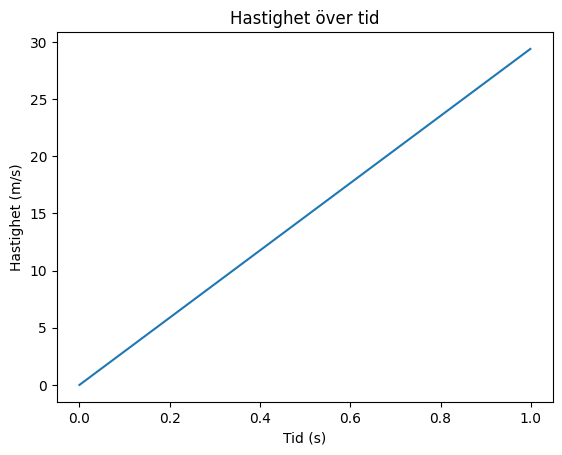

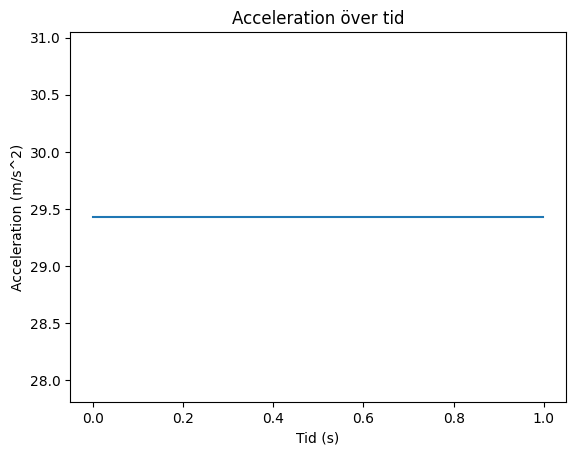

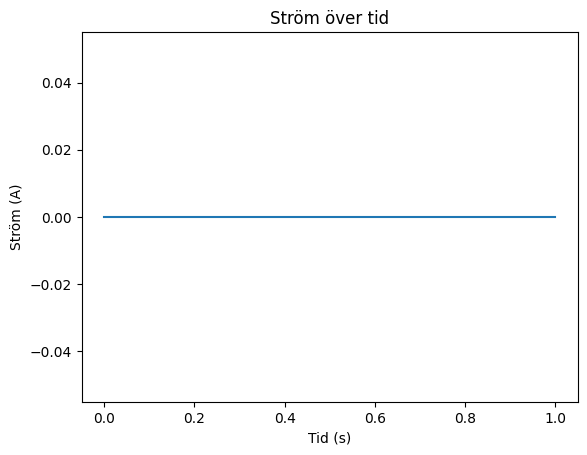

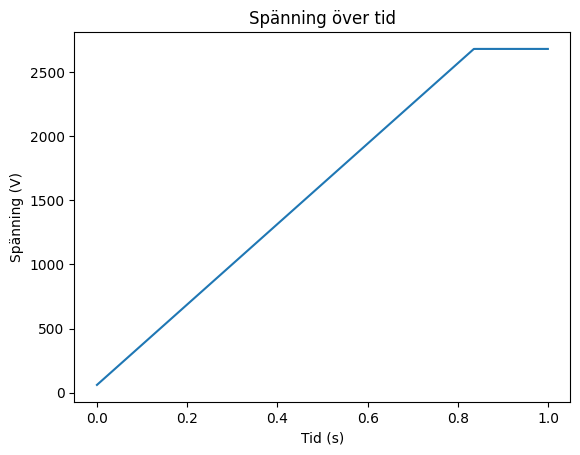

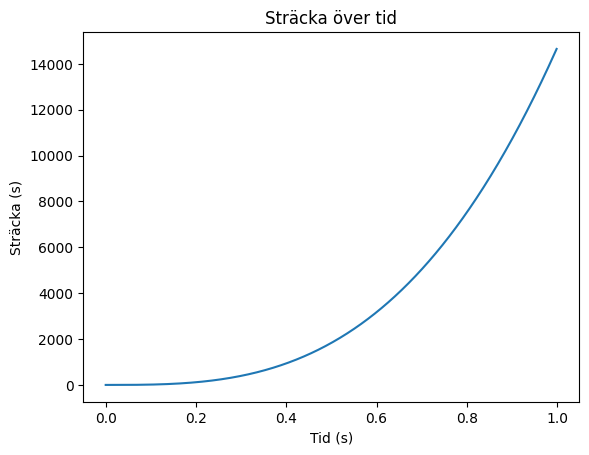

None


In [5]:
#=====================================================================
#-----------------------Simulering---------------------------------------
#=====================================================================
#-----------------Simulering funktion------------------------------------------
x = 0                           #Variabel för att bestämma spänning- eller ström styrd
m = 1000                        #(kg) massan
alpha = 0                       #(grader) lutningen i radianer (grader * pi/180)
U = [2679, x]                   #(v) 
I = [669, 1-x]                  #(A)
I_EM = 0                        #(A) 
def sim(m,alpha, U, I):         #simulerig med insignalerna m, alpha, U, I 
    if U[1]==True:              #konstant spänning / dvs spänningstyrd
        simtyp = 1
        U = U[0]                #U=2679 (V)
    else: 
        simtyp = 0              #Konstant ström / dvs strömstyrd
        I_EM = I[0]             #I= 669 (A)

    N = 1000                    #Antal iterrationer 
    dt = 0.001                   #(s) Tidsteg (start fråm 1ms)
    t_tot = N *dt               #(s) Totala simuleringstid 
#------------------Skapar vektorer för att lagra in resultat-------------
    t_vec = np.zeros(N)         #tid            ex.[0,0,....,0]
    v_vec = np.zeros(N)         #hastighet      ex.[0,0,....,0]
    a_vec = np.zeros(N)         #acceleration   ex.[0,0,....,0]
    ia_vec = np.zeros(N)        #ankarstörm     ex.[0,0,....,0]
    U_vec = np.zeros(N)         #spänning       ex.[0,0,....,0]
    s_vec = np.zeros(N)         #sträcka        ex.[0,0,....,0]

    for k in range(0,N):        #Från 0 till 999 (1000 iter.)
        t_vec[k]= k * dt                                #Sparar tiden för tillstånd k 
        #Mekaniska krafter från omvärden som verkar på fordonet
        F_aero_1 = F_aero(v_vec[k])                     #Räknar luftmotsåndet i tillstånd k för hastigheten i det tillståndet
        F_roll_1 = F_roll(alpha,v_vec[k], m)            #Räknar friktion i tillstånd k för hastigheten i det tillståndet
        F_grad_1 = F_grad(alpha,m)                      #Räknar lutning i tillstånd k för hastigheten i det tillståndet
        F_motstånd= F_aero_1 + F_roll_1 + F_grad_1      #Totala motståndet som verkar på fordonet
        #Mekaniksa kraften vi får från motorn
        if simtyp==1:                                   #Fallet spänningstyrd
            I_EM = (U - lamda * w_r(v_vec[k]))/Ra 
            if I_EM > 669:                             #Begränsar strömmen till max ström
                I_EM = 669
            ia_vec[k]=I_EM                              #Sparar värden för strömmen för varje tillstånd
        else:                                           #Strömstyrd
            U_vec[k] = I_EM * Ra + lamda * w_r(v_vec[k])  #Sparar värden för späningen för varje tillstånd
            if U_vec[k] > 2679:                         #Begränsar spänningen till max spänning
                U_vec[k] = 2679
        T_hjul = n*i*(T_e(I_EM)-T_f)                    #(Nm) Räknar hjulensvridmoment beroende av strömmen
        F_trac = T_hjul/r_hjul                          #(N) Dragkraften vid hjulen    
        F_net = F_trac - F_motstånd                     #(N) Nettokraften som får fordonet att röra sig
        a = F_net/m                                     #(m/s^2) Accelerationen
        if a > mu * g:                                 #Kollar om accelerationen är större än max acceleration
            a = mu * g                                 #Sätter accelerationen till max acceleration
        a_vec[k] = a                                    #Sparar accel i varje tillstånd
        if k < N - 1:
            v_vec[k+1] = v_vec[k] + (a * dt)            #(Eulers-metod) Sparar hastigheten i nästa tillstånd
            #S = v * t + (a*t^2)/2
            s_vec[k+1] = s_vec[k] + (v_vec[k] * k * dt) + (a * ((k*dt)**2)) / 2 #Sparar sträckan i nästa tillstånd
    
#------------------------------------Plotar vektorerna -------------------------------
    #0 = ingen graf, 1 = fem separata, 2 = en sammanställd
    toggle = 1   #Ändra denna om du vill byta graf
    if toggle == 1:
        plt.plot(t_vec,v_vec)
        plt.title("Hastighet över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Hastighet (m/s)")
        plt.show()

        plt.plot(t_vec,a_vec)
        plt.title("Acceleration över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Acceleration (m/s^2)")
        plt.show()

        plt.plot(t_vec,ia_vec)
        plt.title("Ström över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Ström (A)")
        plt.show()

        plt.plot(t_vec,U_vec)
        plt.title("Spänning över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Spänning (V)")
        plt.show()

        plt.plot(t_vec,s_vec)
        plt.title("Sträcka över tid")
        plt.xlabel("Tid (s)")
        plt.ylabel("Sträcka (s)")
        plt.show()
    #Om man vill ha allt i en graf:
    if toggle == 2:
        plt.plot(t_vec, v_vec, label="Hastighet")
        plt.plot(t_vec, a_vec, label="Acceleration")
        plt.plot(t_vec, ia_vec, label="Ström")
        plt.plot(t_vec, U_vec, label="Spänning")
        plt.plot(t_vec, s_vec, label="Sträcka")
        plt.title("Sammanställd graf")
        plt.xlabel("Tid (s)")
        plt.ylabel("Mätdata")
        plt.legend()
        plt.grid(True)
        plt.show()
print(sim(m, alpha, U, I))